## Определение тональности текстов отзывов на сайте [YELP](https://www.yelp.com/dataset/challenge) одномерной сверточной нейросетью

Учебный курс "[Нейросети для анализа текстов](https://www.asozykin.ru/courses/nnpython)".

Чтобы запускать и редактировать код, сохраните копию этого ноутбука себе (File->Save a copy in Drive...). Свою копию вы сможете изменять и запускать.

Не забудьте подключить GPU, чтобы сеть обучалась быстрее (Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU).



In [0]:
%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [0]:
num_words = 10000
max_review_len = 100

## Загрузка набора данных

In [3]:
!wget https://www.dropbox.com/s/ufbhk3kadtnn6h0/yelp_review_polarity_csv.tgz?dl=1 -O yelp_review_polarity_csv.tgz

--2020-04-04 20:37:11--  https://www.dropbox.com/s/ufbhk3kadtnn6h0/yelp_review_polarity_csv.tgz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/ufbhk3kadtnn6h0/yelp_review_polarity_csv.tgz [following]
--2020-04-04 20:37:12--  https://www.dropbox.com/s/dl/ufbhk3kadtnn6h0/yelp_review_polarity_csv.tgz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucaf71d093aa44e1250a3b7c5b96.dl.dropboxusercontent.com/cd/0/get/A1NGdvTCsqwwhKyHx3Br4N8DqJ8di82erQ898LpPY7sO7M-hLGLW8tPzumHL5Vz_un2tk_kmdgtPm-XmkT3cZzrE1ffE8_UNpuigTaT_IDRnX-i6owU54DbwWO5yLHeNzOY/file?dl=1# [following]
--2020-04-04 20:37:12--  https://ucaf71d093aa44e1250a3b7c5b96.dl.dropboxusercontent.com/cd/0/get/A1NGdvTCsqwwhKyHx3Br4N8DqJ8di82erQ898LpPY7sO7M-hLGLW8tPzumHL5Vz_

In [4]:
!tar -xvf yelp_review_polarity_csv.tgz

yelp_review_polarity_csv/
yelp_review_polarity_csv/train.csv
yelp_review_polarity_csv/readme.txt
yelp_review_polarity_csv/test.csv


## Просматриваем данные

In [5]:
!cat yelp_review_polarity_csv/readme.txt

Yelp Review Polarity Dataset

Version 1, Updated 09/09/2015

ORIGIN

The Yelp reviews dataset consists of reviews from Yelp. It is extracted from the Yelp Dataset Challenge 2015 data. For more information, please refer to http://www.yelp.com/dataset_challenge

The Yelp reviews polarity dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the above dataset. It is first used as a text classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advances in Neural Information Processing Systems 28 (NIPS 2015).


DESCRIPTION

The Yelp reviews polarity dataset is constructed by considering stars 1 and 2 negative, and 3 and 4 positive. For each polarity 280,000 training samples and 19,000 testing samples are take randomly. In total there are 560,000 trainig samples and 38,000 testing samples. Negative polarity is class 1, and positive class 2.

The files train.csv and test.csv contain all the

In [6]:
!head yelp_review_polarity_csv/train.csv

"1","Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars."
"2","Been going to Dr. Goldberg for over 10 years. I think I was one of his 1st patients when he started at MHMG. He's been great over the years and is really all about the big picture. It is because of him, not my now former gyn Dr. Markoff, that I found out I have fibroids. He explores all options with you and is very patient and understanding. H

In [7]:
!head yelp_review_polarity_csv/test.csv

"2","Contrary to other reviews, I have zero complaints about the service or the prices. I have been getting tire service here for the past 5 years now, and compared to my experience with places like Pep Boys, these guys are experienced and know what they're doing. \nAlso, this is one place that I do not feel like I am being taken advantage of, just because of my gender. Other auto mechanics have been notorious for capitalizing on my ignorance of cars, and have sucked my bank account dry. But here, my service and road coverage has all been well explained - and let up to me to decide. \nAnd they just renovated the waiting room. It looks a lot better than it did in previous years."
"1","Last summer I had an appointment to get new tires and had to wait a super long time. I also went in this week for them to fix a minor problem with a tire they put on. They \""fixed\"" it for free, and the very next morning I had the same issue. I called to complain, and the \""manager\"" didn't even apolog

In [8]:
!wc -l yelp_review_polarity_csv/train.csv
!wc -l yelp_review_polarity_csv/test.csv

560000 yelp_review_polarity_csv/train.csv
38000 yelp_review_polarity_csv/test.csv


## Загружаем данные в память

Читаем данные из файла

In [0]:
train = pd.read_csv('yelp_review_polarity_csv/train.csv', 
                    header=None, 
                    names=['Class', 'Review'])

In [10]:
train

,Class,Review
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...
...,...,...
559995,2,Ryan was as good as everyone on yelp has claim...
559996,2,Professional \nFriendly\nOn time AND affordabl...
559997,1,Phone calls always go to voicemail and message...
559998,1,Looks like all of the good reviews have gone t...


Выделяем данные для обучения

In [0]:
reviews = train['Review']

In [12]:
reviews[:5]

0    Unfortunately, the frustration of being Dr. Go...
1    Been going to Dr. Goldberg for over 10 years. ...
2    I don't know what Dr. Goldberg was like before...
3    I'm writing this review to give you a heads up...
4    All the food is great here. But the best thing...
Name: Review, dtype: object

Выделяем правильные ответы

In [0]:
y_train = train['Class'] - 1

In [14]:
y_train

0         0
1         1
2         0
3         0
4         1
         ..
559995    1
559996    1
559997    0
559998    0
559999    1
Name: Class, Length: 560000, dtype: int64

## Токенизация текста

In [15]:
reviews[:5]

0    Unfortunately, the frustration of being Dr. Go...
1    Been going to Dr. Goldberg for over 10 years. ...
2    I don't know what Dr. Goldberg was like before...
3    I'm writing this review to give you a heads up...
4    All the food is great here. But the best thing...
Name: Review, dtype: object

Создаем токенизатор Keras

In [0]:
tokenizer = Tokenizer(num_words=num_words)

Обучаем токенизатор на отзывах Yelp

In [0]:
tokenizer.fit_on_texts(reviews)

Просматриваем словарь токенизатора

In [18]:
tokenizer.word_index

{'the': 1,
 'and': 2,
 'i': 3,
 'to': 4,
 'a': 5,
 'was': 6,
 'of': 7,
 'it': 8,
 'for': 9,
 'in': 10,
 'is': 11,
 'n': 12,
 'that': 13,
 'my': 14,
 'we': 15,
 'this': 16,
 'but': 17,
 'with': 18,
 'they': 19,
 'you': 20,
 'on': 21,
 'not': 22,
 'have': 23,
 'had': 24,
 'at': 25,
 'were': 26,
 'so': 27,
 'are': 28,
 'food': 29,
 'be': 30,
 'place': 31,
 'me': 32,
 'there': 33,
 'good': 34,
 'as': 35,
 'out': 36,
 'all': 37,
 'like': 38,
 'if': 39,
 'just': 40,
 'our': 41,
 'very': 42,
 'get': 43,
 'one': 44,
 'here': 45,
 'time': 46,
 'when': 47,
 'up': 48,
 'or': 49,
 'from': 50,
 'great': 51,
 'service': 52,
 'would': 53,
 'back': 54,
 'their': 55,
 'about': 56,
 'no': 57,
 'go': 58,
 'an': 59,
 'what': 60,
 'really': 61,
 'he': 62,
 "it's": 63,
 'she': 64,
 'which': 65,
 'will': 66,
 'some': 67,
 'only': 68,
 'been': 69,
 'us': 70,
 'your': 71,
 'because': 72,
 'more': 73,
 'even': 74,
 'can': 75,
 'them': 76,
 'by': 77,
 "don't": 78,
 'got': 79,
 'other': 80,
 'after': 81,
 'do': 8

Преобразуем отзывы Yelp в числовое представление

In [0]:
sequences = tokenizer.texts_to_sequences(reviews)

Просматриваем отзывы в числовом представлении

In [20]:
index = 100
print(reviews[index])
print(sequences[index])

In general I do like Shake N' Steak, but this location is a hit or miss location!  You never know what kind of quality or service you're going to find here.  A friend and myself went a few weeks back after a movie and it had to be one of the worst trips there EVER!  You can't entirely blame the waitress since she was the only one there for the entire place...poor scheduling on the manager's part. However, while she can't be accountable for the slooooow service, she was accountable for both orders being incorrect.  The burgers were over cooked and the fries were soggie and the milkshake was runny at best...\n\nBy far my worst visit to Steak n' Shake!
[10, 1186, 3, 82, 38, 1888, 4625, 309, 17, 16, 198, 11, 5, 689, 49, 943, 198, 20, 88, 113, 60, 314, 7, 242, 49, 52, 238, 116, 4, 185, 45, 5, 295, 2, 493, 98, 5, 162, 722, 54, 81, 5, 1094, 2, 8, 24, 4, 30, 44, 7, 1, 384, 2625, 33, 151, 20, 208, 2833, 2723, 1, 291, 167, 64, 6, 1, 68, 44, 33, 9, 1, 575, 31, 564, 5356, 21, 1, 7244, 377, 277, 16

In [21]:
tokenizer.word_index['unfortunately']

707

Ограничиваем длину отзывов

In [0]:
x_train = pad_sequences(sequences, maxlen=max_review_len)

In [23]:
x_train[:5]

array([[   7,    1,  137,  112,   24,   18,   27,  189,   80, 3128,   10,
        2636,   34, 1416,  462,  129,    8,  519,   13,  177,  129,  803,
          88, 3812,    1,  446,    8,  392,  841,  115,  360,    7, 4136,
        1438,    4,   43,   59, 1266,  118,   95,   46,    9,   13,   49,
        1687,    4,  418,   18,    8,    3,   23,  563,  178,   16,  460,
          18,  189,   80, 3128,    2,    3,   40,   78,   43,    8,   20,
          23,  644, 1343,   20,   23, 3252,   18, 2921,  637,  227,  430,
         476, 4312,    1,  446,   63,    2,   22,  215,    1,   63,   18,
        2269,   13,    3,  249,   13,    3,   23,    4,  163,  939,  115,
         237],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,   69,  116,
           4,  939,    9,   94,  201,  274,    3,  142,    3,    6,   44,
           7,  177, 2084, 3252,   47,   62,  422,   25, 1334,   69,   51,
          94,    1,  274,    2,   11,   61,   37,   56,    1,  219, 1403,
           8,   11,   7

## Создаем нейронную сеть

In [0]:
model = Sequential()
model.add(Embedding(num_words, 64, input_length=max_review_len))
model.add(Conv1D(250, 5, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [0]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           640000    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 250)           80250     
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32128     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 752,507
Trainable params: 752,507
Non-trainable params: 0
__________________________________________________

## Обучаем нейронную сеть

Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model.h5`

In [0]:
model_save_path = 'best_model.h5'
checkpoint_callback = ModelCheckpoint(model_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [28]:
history = model.fit(x_train, 
                    y_train, 
                    epochs=4,
                    batch_size=128,
                    validation_split=0.1,
                    callbacks=[checkpoint_callback])

Epoch 1/4
3938/3938 [==============================] - ETA: 0s - loss: 0.1863 - accuracy: 0.9244
Epoch 00001: val_accuracy improved from -inf to 0.95329, saving model to best_model.h5
3938/3938 [==============================] - 44s 11ms/step - loss: 0.1863 - accuracy: 0.9244 - val_loss: 0.1210 - val_accuracy: 0.9533
Epoch 2/4
3938/3938 [==============================] - ETA: 0s - loss: 0.1244 - accuracy: 0.9534
Epoch 00002: val_accuracy improved from 0.95329 to 0.95595, saving model to best_model.h5
3938/3938 [==============================] - 44s 11ms/step - loss: 0.1244 - accuracy: 0.9534 - val_loss: 0.1187 - val_accuracy: 0.9559
Epoch 3/4
3936/3938 [============================>.] - ETA: 0s - loss: 0.0896 - accuracy: 0.9678
Epoch 00003: val_accuracy did not improve from 0.95595
3938/3938 [==============================] - 44s 11ms/step - loss: 0.0897 - accuracy: 0.9677 - val_loss: 0.1232 - val_accuracy: 0.9546
Epoch 4/4
3935/3938 [============================>.] - ETA: 0s - loss: 0

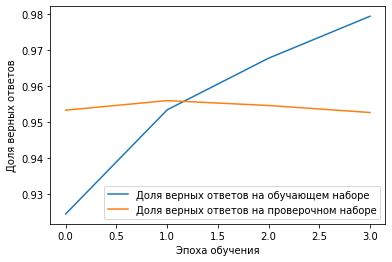

In [29]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Загружаем модель с лучшей долей правильных ответов на проверочном наборе данных

In [0]:
model.load_weights(model_save_path)

## Загружаем набор данных для тестирования

In [0]:
test = pd.read_csv('yelp_review_polarity_csv/test.csv', 
                    header=None, 
                    names=['Class', 'Review'])

In [32]:
test

,Class,Review
0,2,"Contrary to other reviews, I have zero complai..."
1,1,Last summer I had an appointment to get new ti...
2,2,"Friendly staff, same starbucks fair you get an..."
3,1,The food is good. Unfortunately the service is...
4,2,Even when we didn't have a car Filene's Baseme...
...,...,...
37995,1,If I could give 0...I would. Don't do it.
37996,2,Items Selected:\nChocolate Cinnamon Horn\nSmal...
37997,1,Expensive lunch meals. Fried pickles were goo...
37998,1,Highly overpriced and food was cold. Our waitr...


Преобразуем отзывы в числовое представление

Обратите внимание, что нужно использовать токенизатор, обученный на наборе данных train.

In [0]:
test_sequences = tokenizer.texts_to_sequences(test['Review'])

In [0]:
x_test = pad_sequences(test_sequences, maxlen=max_review_len)

In [35]:
x_test[:5]

array([[   9,    1,  546,  148,  274,  165,    2, 1221,    4,   14,  137,
          18,  289,   38, 8346, 2311,  257,  511,   28, 1167,    2,  113,
          60,  568,  520, 1426,   16,   11,   44,   31,   13,    3,   82,
          22,  249,   38,    3,  144,  173,  694, 2235,    7,   40,   72,
           7,   14,   80, 2540, 5951,   23,   69,    9,   21,   14,    7,
        1558,    2,   23, 1696,   14, 1894, 1775,  470,   17,   45,   14,
          52,    2, 1346, 5923,   95,   37,   69,   91, 1024,    2,  311,
          48,    4,   32,    4, 1480, 1037,   19,   40, 4124,    1,  317,
         127,    8,  562,    5,  203,  114,   99,    8,   90,   10, 1168,
         274],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,  182, 1243,    3,   24,
          59,  728,    4,   43,  159, 2073,    2,   24,    4,  154,    5,
         315,  190,   4

Правильные ответы

In [0]:
y_test = test['Class'] - 1

In [37]:
y_test

0        1
1        0
2        1
3        0
4        1
        ..
37995    0
37996    1
37997    0
37998    0
37999    0
Name: Class, Length: 38000, dtype: int64

## Оцениваем качество работы сети на тестовом наборе данных

In [38]:
model.evaluate(x_test, y_test, verbose=1)

1188/1188 [==============================] - 3s 2ms/step - loss: 0.1463 - accuracy: 0.9433


[0.1462959349155426, 0.9432631731033325]

## Оцениваем тональность на собственном отзыве

In [0]:
text = '''The SmartBurger restaurant is awful. It’s a small shabby place. 
The food is really bad and very expensive.  The host and waiters are rud. 
I will never visit the SmartBurger again!
'''

In [0]:
sequence = tokenizer.texts_to_sequences([text])

In [41]:
sequence

[[1,
  104,
  11,
  692,
  5,
  197,
  5272,
  31,
  1,
  29,
  11,
  61,
  143,
  2,
  42,
  502,
  1,
  1526,
  2,
  1713,
  28,
  3,
  66,
  88,
  285,
  1,
  108]]

In [0]:
data = pad_sequences(sequence, maxlen=max_review_len)

In [43]:
data

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    1,  104,   11,  692,
           5,  197, 5272,   31,    1,   29,   11,   61,  143,    2,   42,
         502,    1, 1526,    2, 1713,   28,    3,   66,   88,  285,    1,
         108]], dtype=int32)

In [0]:
result = model.predict(data)

In [45]:
result

array([[0.00026336]], dtype=float32)

In [46]:
if result < 0.5:
    print('Отзыв отрицательный')
else:
    print('Отзыв положительный')


Отзыв отрицательный


## Задания для самостоятельной работы

1. Меняйте гиперпараметры нейросети, чтобы повысить качество работы:
  - Длину окна свертки (поробуйте 3, 5, 7 и 9).
  - Количество карт признаков в сверточном слое.
  - Длину вектора представления слов в слое Embedding.
  - Количество сверточных слоев.
  - Количествой нейронов в полносвязном слое для классификации.
  - Параметр Dropout
  - Тип оптимизатора (`adam`, `rmsprop` и др.)
  - Количество эпох обучения.
  - Рармер мини-выборки.

2. Попробуйте применить вместо токенизатора Keras более совершенные:
  - [spaCy Tokenizer](https://spacy.io/usage/spacy-101#annotations-token)
  - [Huggingface Tokenizers](https://github.com/huggingface/tokenizers)
  
    Эти токенизаторы сложнее в использовании, но работают лучше.
3. Переделайте нейросеть для распознавания набора данных [Yelp reviews - Full](https://s3.amazonaws.com/fast-ai-nlp/yelp_review_full_csv.tgz), в котором 4 класса по количеству звезд у отзывов.

## Полезные ссылки

1. [Определение тональности текстов отзывов на сайте YELP сетью LSTM](https://colab.research.google.com/drive/19olgYyZ4N5fh8RIPtHxkso2N5HD1yg0X).
2. [Использование командной строки Linux в Colab](https://colab.research.google.com/drive/1vFGZ2nDS0ukNGXPL-0avK097afYQILyq).